## CHALLENGE 3 : LM Survival Sentinel
In this challenge, participants will build machine learning models to predict whether a person affected by breast cancer is likely to survive. The models will be trained on patient data and outcomes, with the goal of providing insights into survival rates based on various health indicators.


In [1]:
import optuna
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
import gym
from gym import spaces
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import paho.mqtt.client as mqtt
import pandas as pd
import numpy as np
import json
from datetime import datetime
import streamlit as st
import plotly.express as px


## charger les donnes



In [2]:
df = pd.read_csv('train.csv')

## Vérification détaillée des données

In [3]:
nul_columns = df.isnull().sum()
nul_columns = nul_columns[nul_columns > 0]

print(nul_columns)



Series([], dtype: int64)


In [4]:
df.describe()

,temperature_C,humidity_percent,outside_temperature_C,outside_humidity_percent,power_consumption_W,fan_speed_rpm,flux
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8.640000e+03
mean,19.995423,40.027208,14.998033,50.010841,299.940517,1000.525584,1.998947e+06
std,7.085500,14.237858,5.758993,17.904970,71.462724,356.975036,5.045837e+05
min,8.562632,13.621021,3.826684,15.043183,171.362693,344.749736,5.000000e+05
25%,12.930861,26.070727,9.439561,32.668310,229.854293,652.003015,1.661138e+06
50%,20.012201,40.091029,14.999069,49.947092,299.913812,1006.320659,1.996852e+06
75%,27.046107,53.993212,20.557547,67.375160,369.600416,1345.370450,2.339467e+06
max,31.430726,66.566475,26.099471,84.566015,424.926868,1645.134074,3.963118e+06


In [5]:
for col in df.columns:
    print(df[col].dtype)

object
float64
float64
float64
float64
float64
float64
int64


# type expoitable pas de probleme

In [6]:
for col in df.columns:
    print(col)
    print(df[col].unique())

timestamp
['2025-04-01 00:00:00' '2025-04-01 00:05:00' '2025-04-01 00:10:00' ...
 '2025-04-30 23:45:00' '2025-04-30 23:50:00' '2025-04-30 23:55:00']
temperature_C
[20.33144063 20.80491103 20.52675511 ... 19.02459813 19.96128469
 19.48010339]
humidity_percent
[43.69732614 38.2572035  42.29063635 ... 35.84955009 42.30939405
 38.67933747]
outside_temperature_C
[14.89603349 14.46153036 15.44764393 ... 15.20542772 16.32148028
 16.7182435 ]
outside_humidity_percent
[50.54164873 47.16768203 46.7944552  ... 45.39325685 47.52670859
 47.75767199]
power_consumption_W
[304.92483485 297.47500953 298.20857023 ... 274.6070615  285.08336886
 296.64911701]
fan_speed_rpm
[1044.90181844 1032.21645617 1046.57516276 ... 1042.16525792  938.48802766
  968.17576251]
flux
[2248357 1930867 2323844 ... 1432182 2254647 1691964]


# due au faite que la data est en time serie en vas changer le format timestamp pour qu'il sois exploitable 

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extraire des composantes temporelles
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Lundi = 0
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Ajouter des features cycliques 
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)


In [8]:
print(type(df)) 

<class 'pandas.core.frame.DataFrame'>


In [9]:
df = df.drop('timestamp',axis= 1)

In [10]:
print(type(df)) 

<class 'pandas.core.frame.DataFrame'>


## visualitation des donnees 


j'ai tester une regression logique sur la data pour voir  une autre relation entre les colonms et survival status 

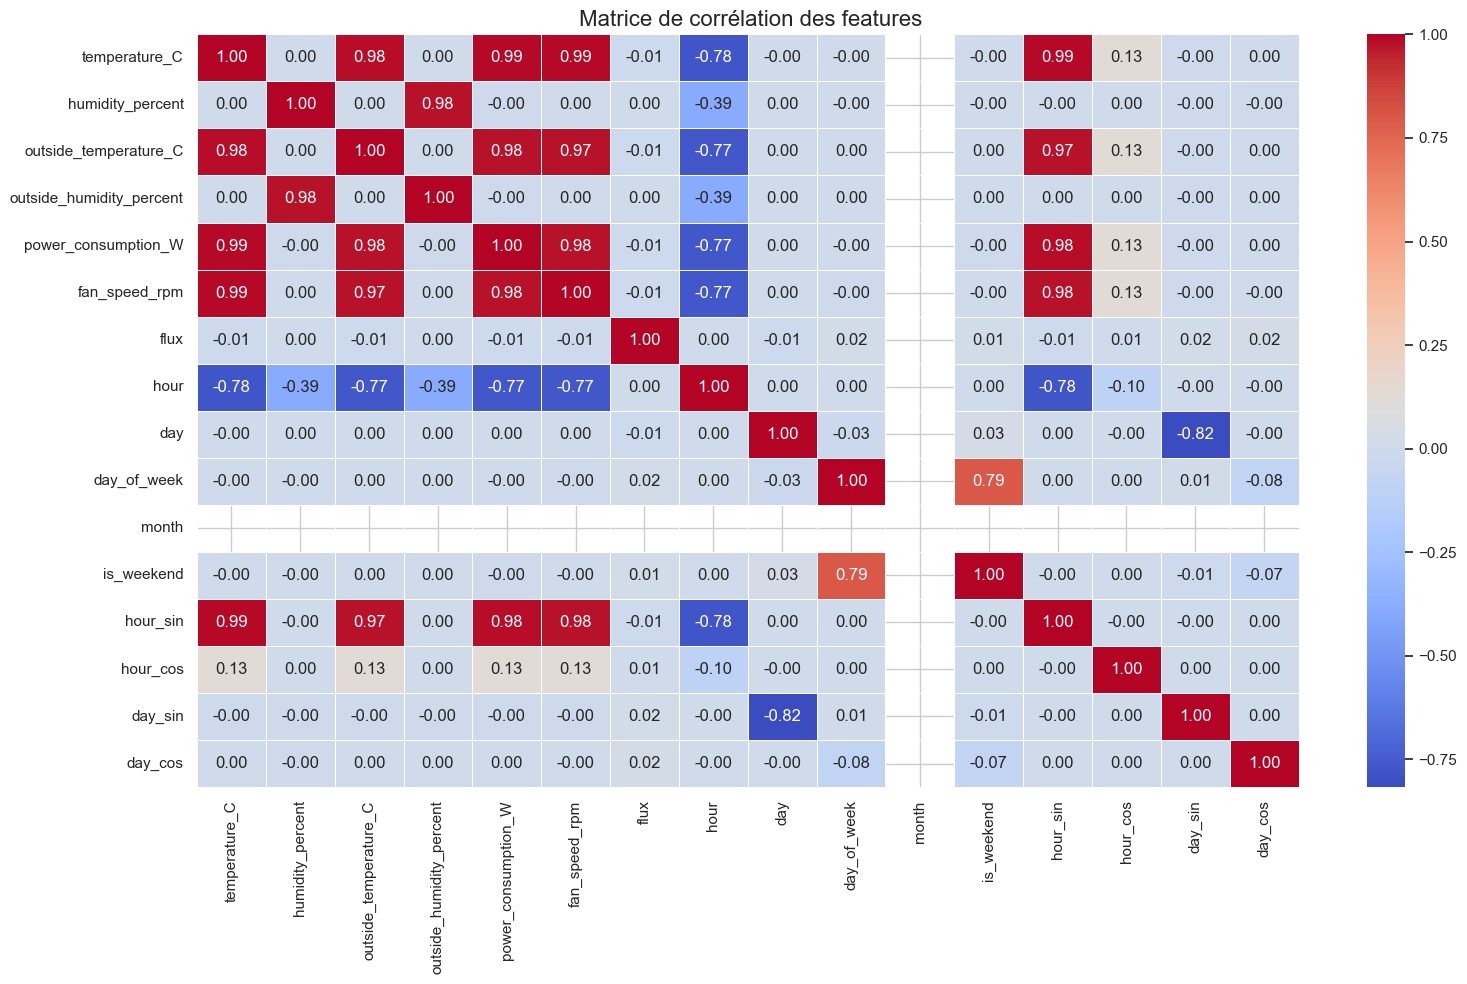

In [11]:
sns.set(style="whitegrid")

#  Heatmap de corrélation
# Permet de visualiser les relations linéaires entre chaque feature
plt.figure(figsize=(16, 10))
plt.title(" Matrice de corrélation des features", fontsize=16)
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.show()


## 📌 Pairplot : visualisation croisée de toutes les paires de variables
## Avec la couleur indiquant la valeur de 'fan_speed_rpm'

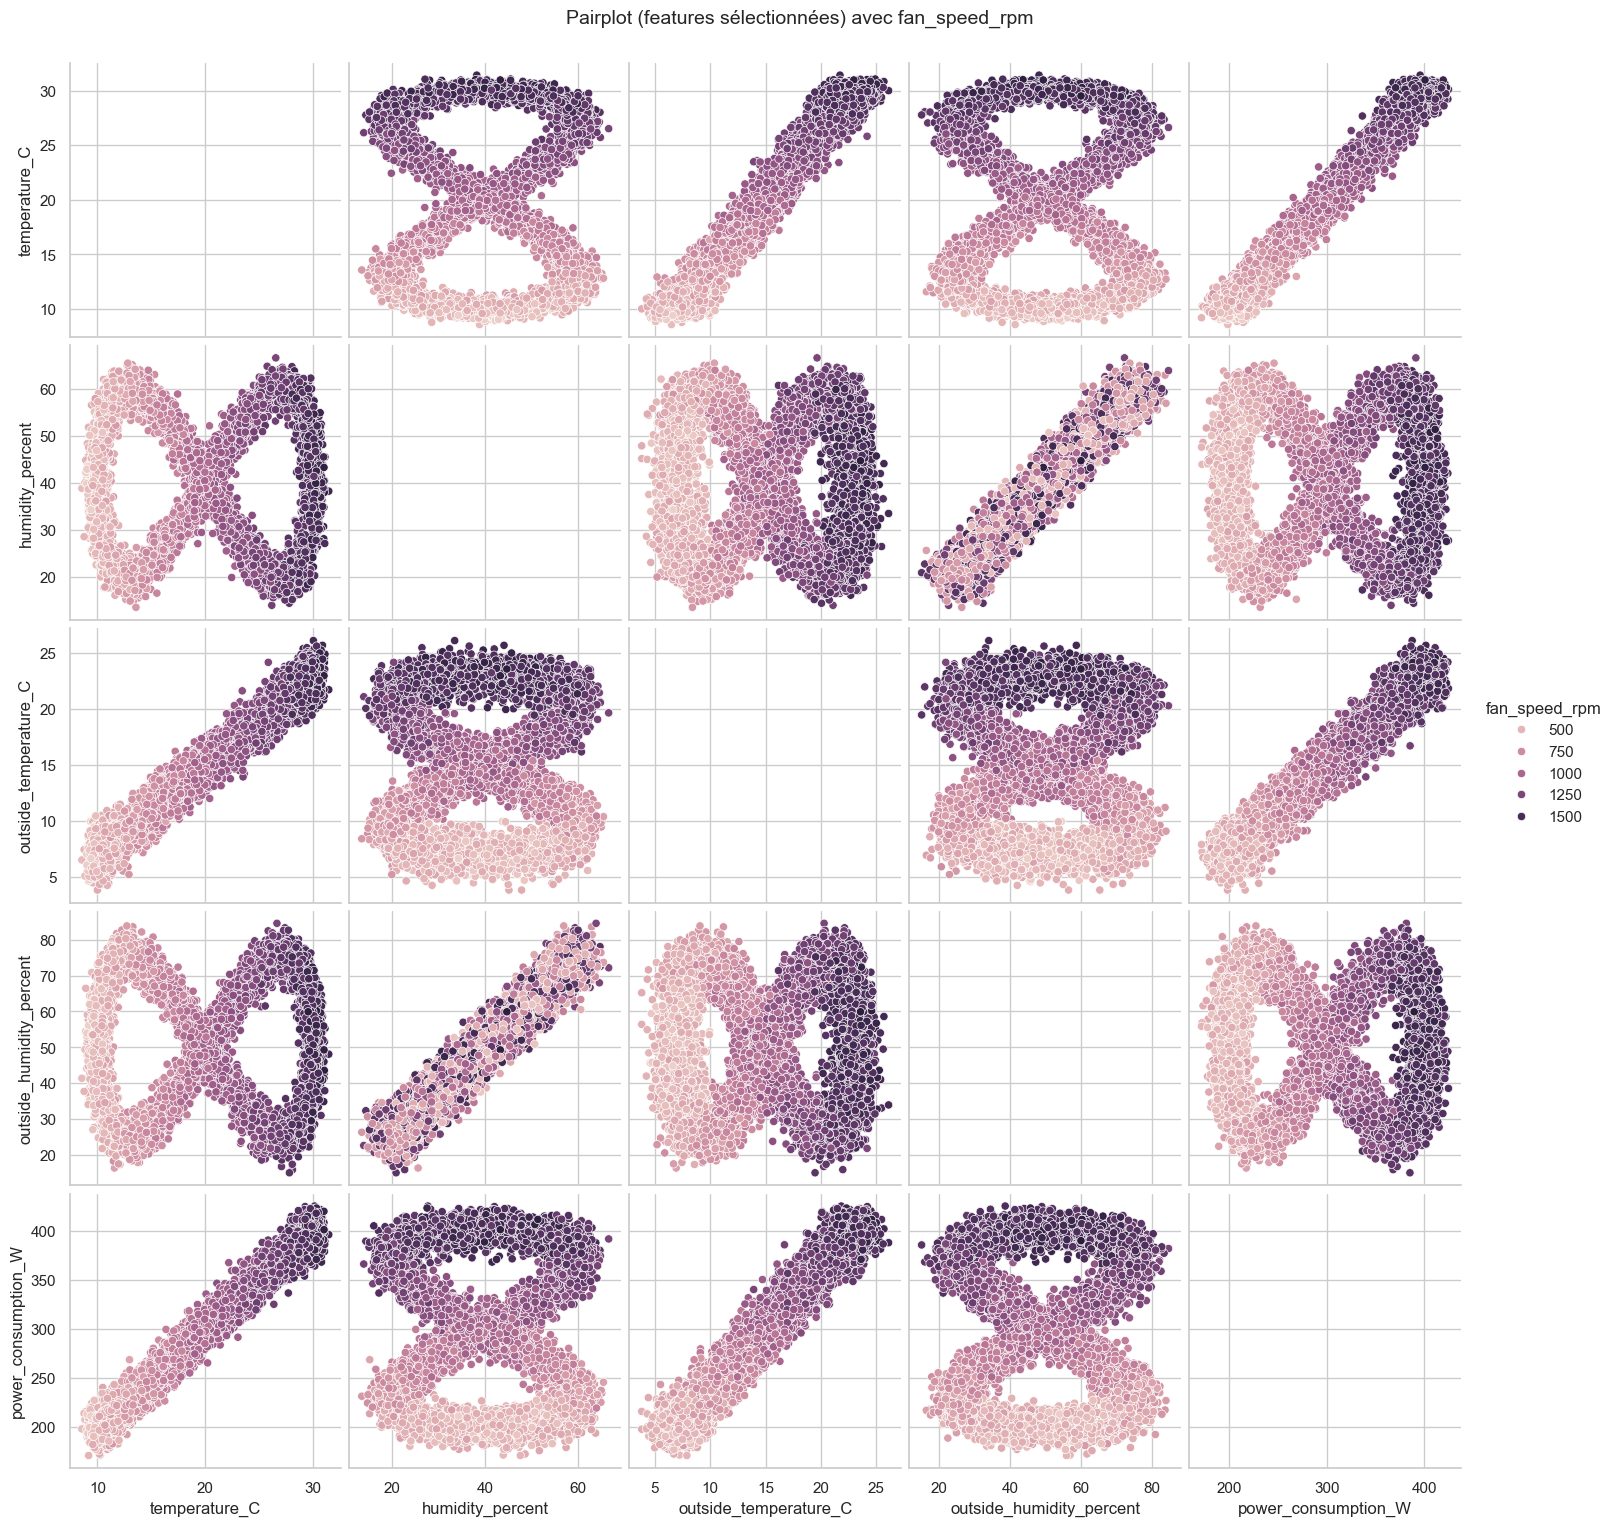

In [12]:
cols_to_plot = ['temperature_C', 'humidity_percent', 'outside_temperature_C', 'outside_humidity_percent', 'power_consumption_W', 'fan_speed_rpm']

sns.pairplot(df[cols_to_plot], hue='fan_speed_rpm', diag_kind='kde', height=3)
plt.suptitle("Pairplot (features sélectionnées) avec fan_speed_rpm", y=1.02, fontsize=14)
plt.show()

##  Distribution de chaque variable
## Affiche la densité de probabilité de chaque feature

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


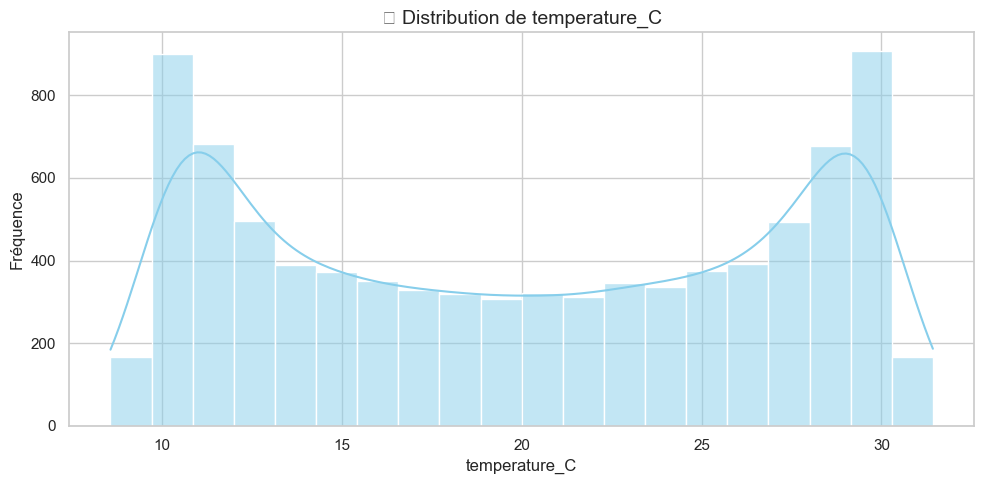

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


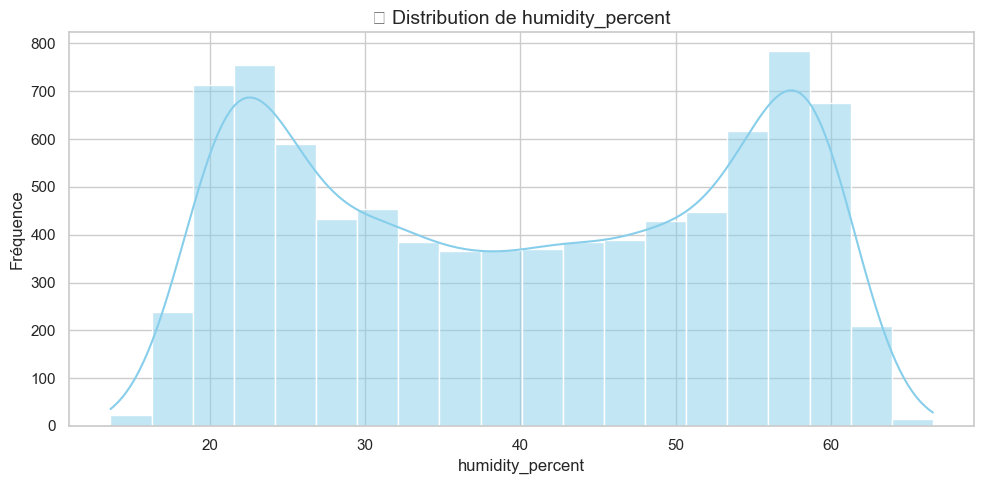

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


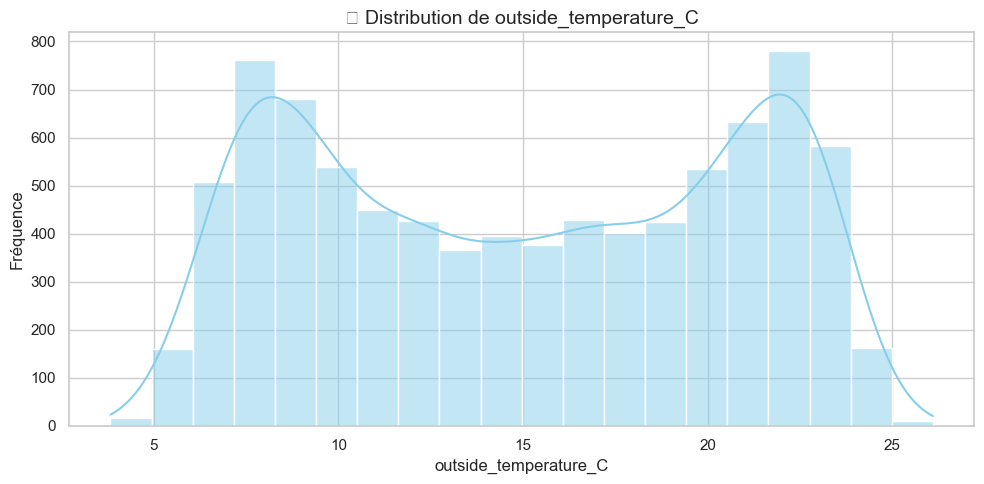

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


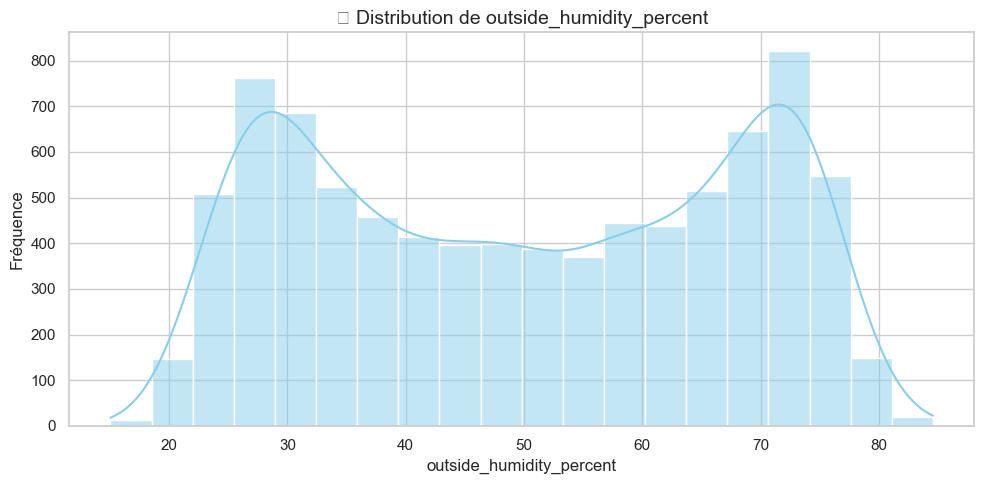

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


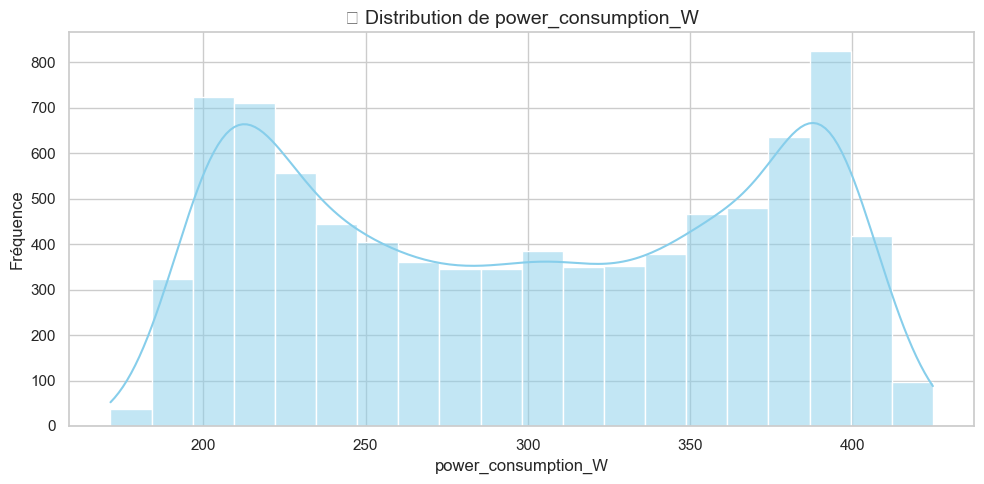

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


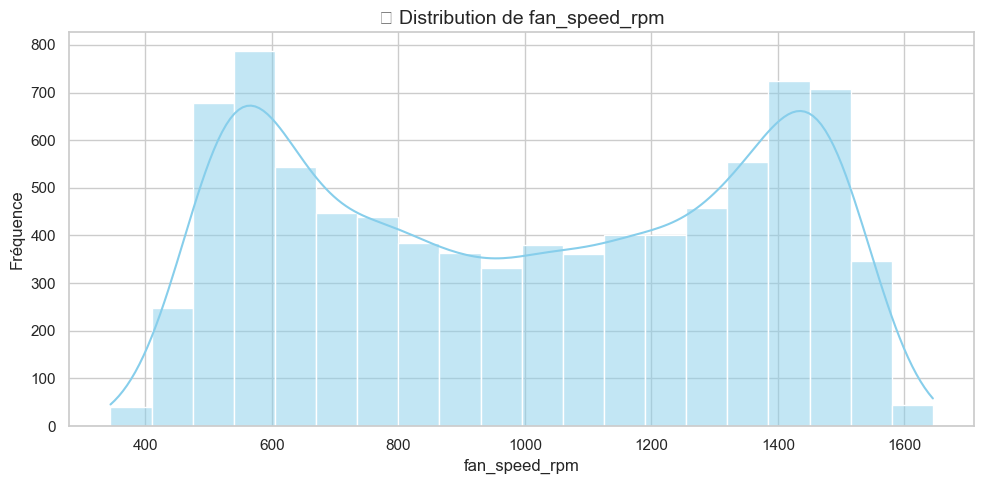

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


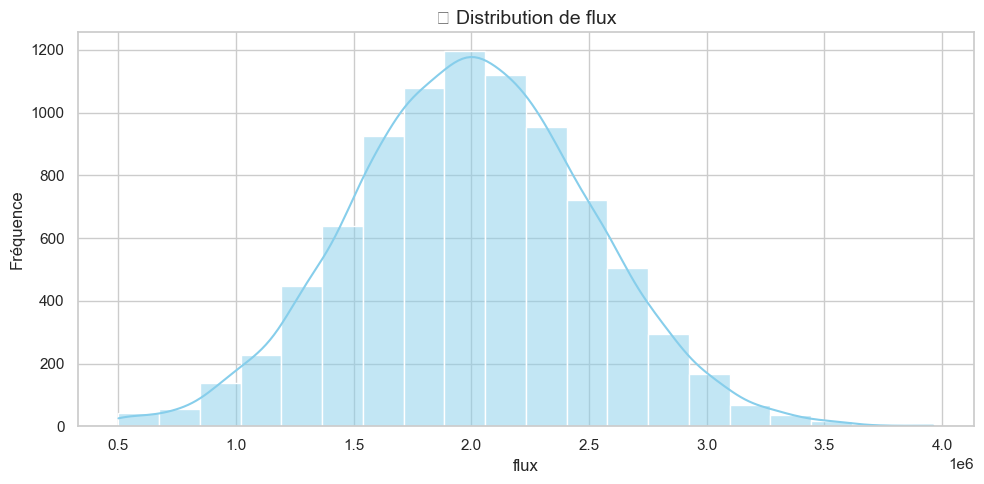

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


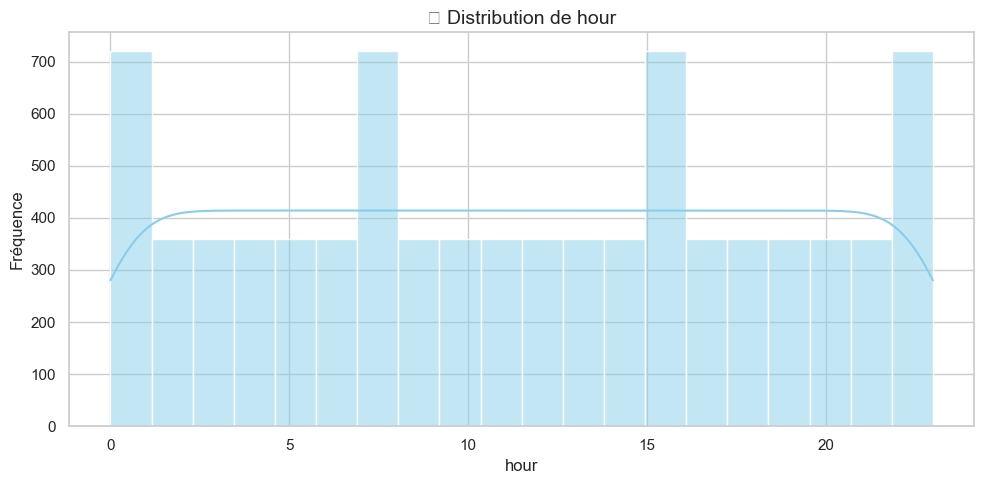

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


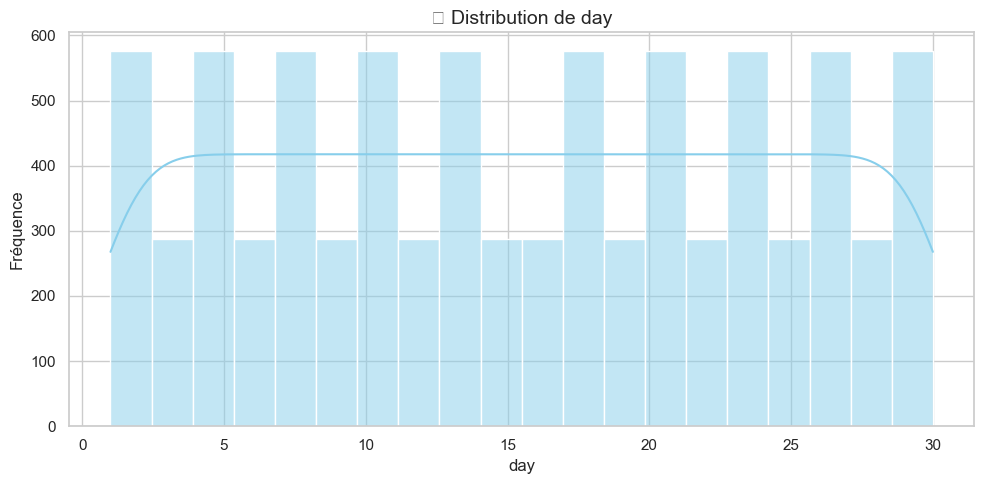

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


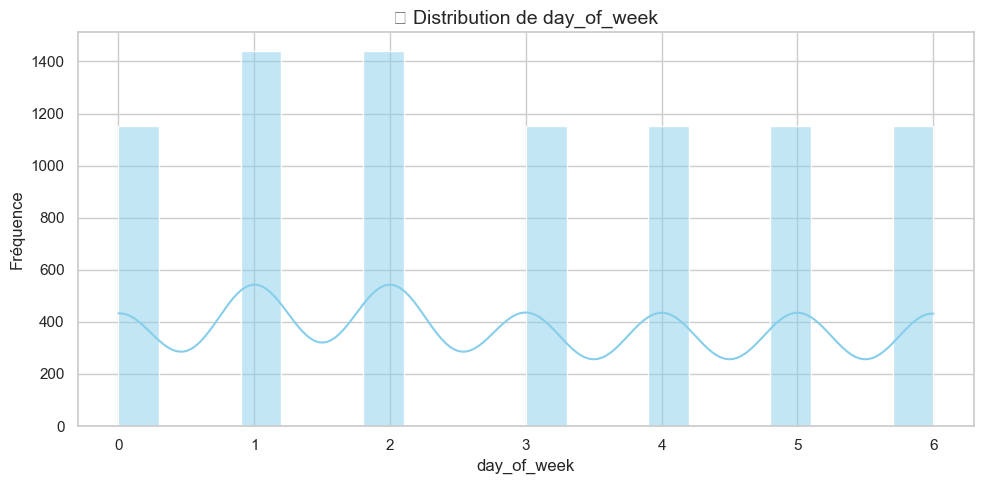

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


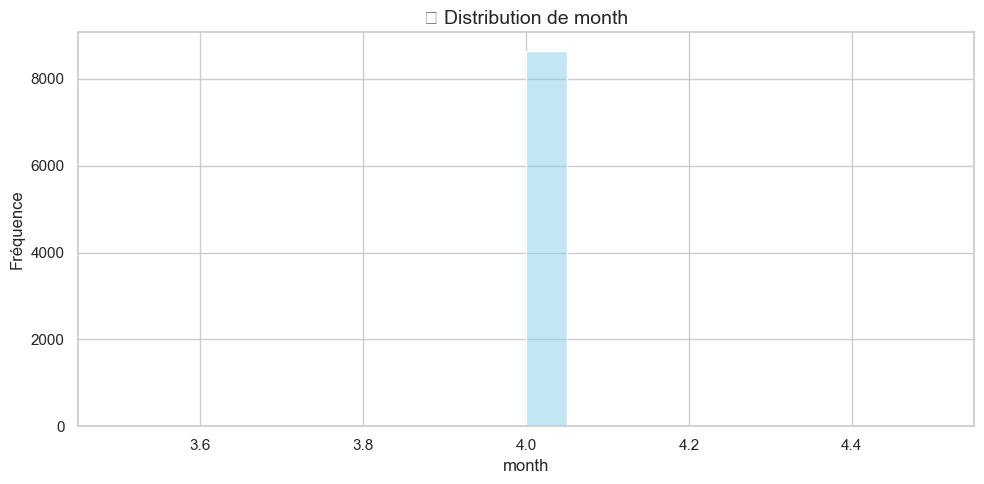

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


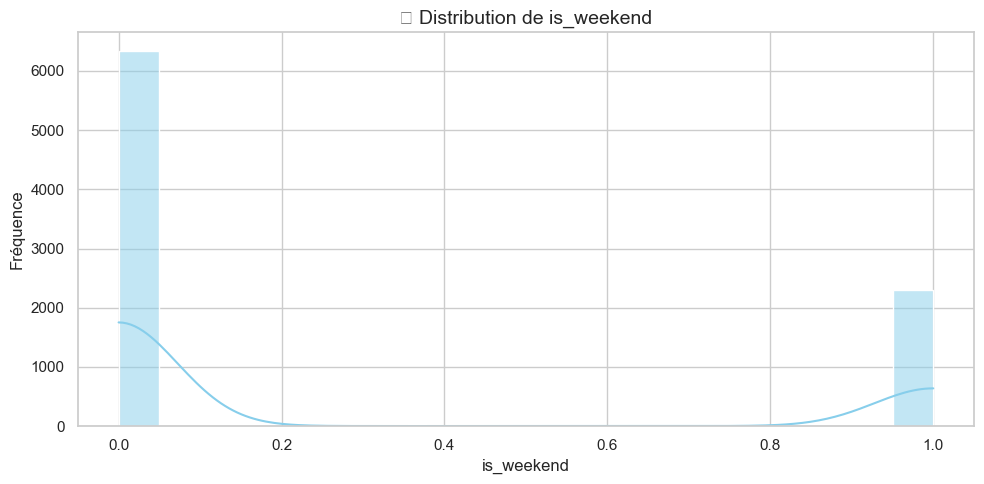

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


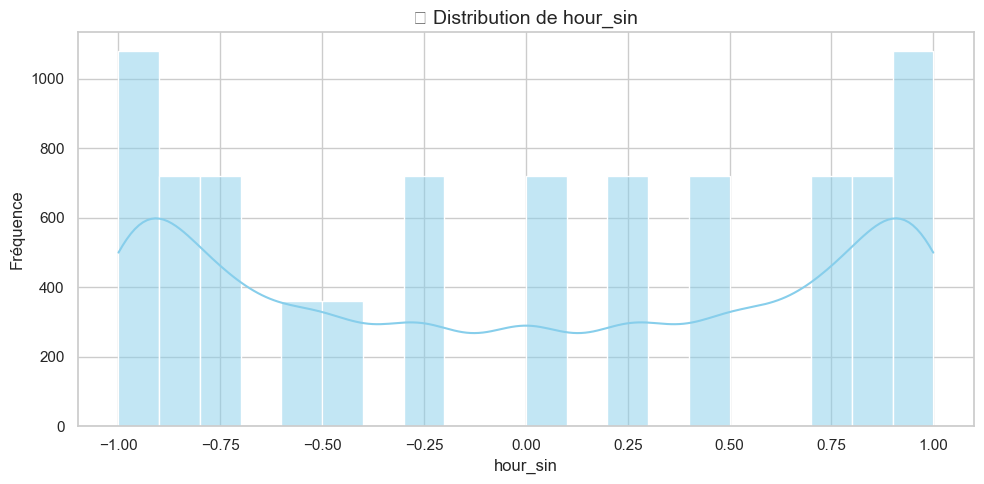

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


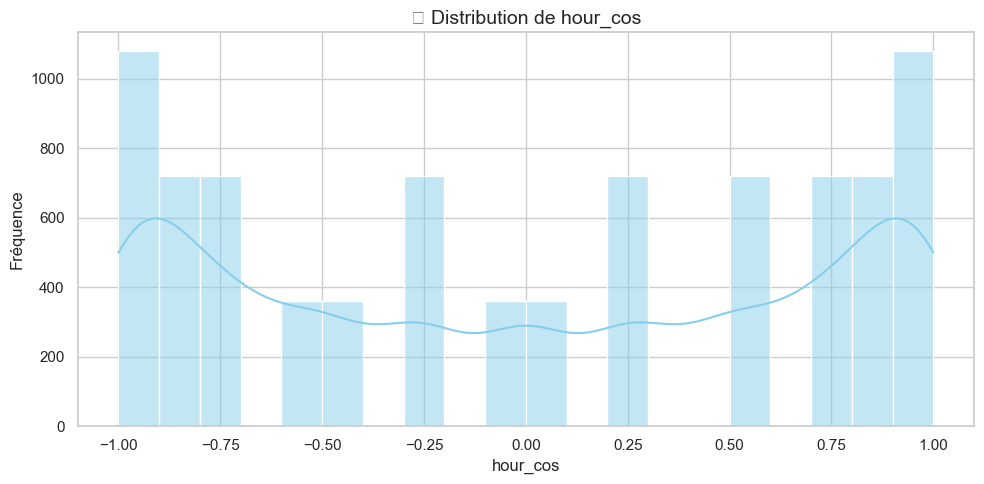

C:\Users\PC\AppData\Local\Temp\ipykernel_29912\151621395.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC\OneDrive\Documents\ilyes\projet\nest\pink\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


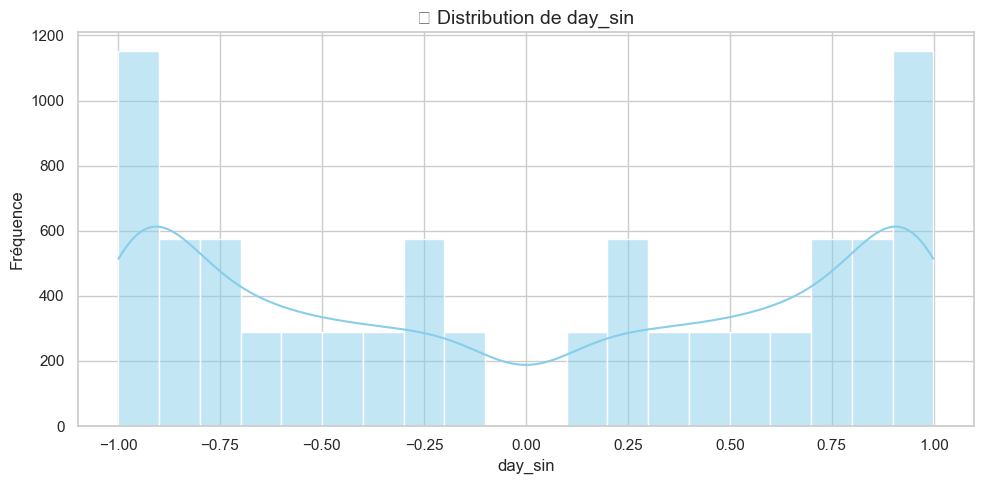

In [13]:
for column in df.columns[:-1]:  
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column], kde=True, bins=20, color='skyblue')
    plt.title(f"📈 Distribution de {column}", fontsize=14)
    plt.xlabel(column)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

## 📌 Boxplot général
## Utile pour détecter les valeurs extrêmes (outliers)

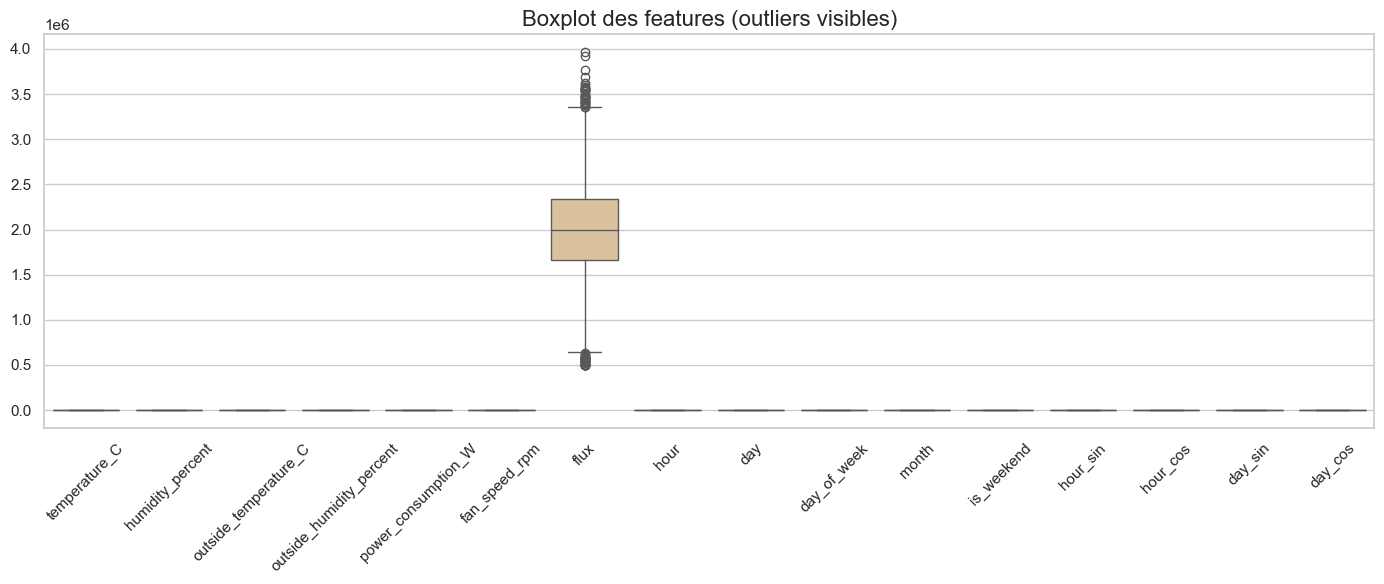

In [14]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, palette="Set2")
plt.title("Boxplot des features (outliers visibles)", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preparation du dataset 




## Nous allons préparer notre dataset de manière à obtenir deux types de prédictions :

"Une prédiction optimale pour le refroidissement, afin d'assurer un confort thermique."

"Une prédiction orientée vers l'économie d'énergie, pour minimiser la consommation électrique."

L’objectif est d’avoir un résultat flexible et dynamique, capable de gérer différents scénarios en combinant les deux prédictions avec des poids adaptables selon la situation (par exemple : niveau de batterie, température extérieure, etc.).


In [15]:
def prepare_data(df):
    # 🔹 1. Création de nouvelles features
    df["delta_temp"] = df["temperature_C"] - df["outside_temperature_C"]
    df["delta_humidity"] = df["humidity_percent"] - df["outside_humidity_percent"]

    # 🔹 2. Définition de la cible
    y = df["fan_speed_rpm"]

    # 🔹 3. Vérifie que 'flux' est bien présente et numérique
    if 'flux' not in df.columns:
        raise ValueError("La colonne 'flux' est manquante dans le DataFrame.")
    if not np.issubdtype(df["flux"].dtype, np.number):
        raise TypeError("La colonne 'flux' doit être numérique.")

    # 🔹 4. Suppression de la cible pour créer les features
    X = df.drop(columns=["fan_speed_rpm"])

    # 🔹 5. Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 🔹 6. Split thermique (confort)
    X_train_thermal, X_test_thermal, y_train_thermal, y_test_thermal = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # 🔹 7. Split énergie (faible consommation)
    low_power_mask = df["power_consumption_W"] < df["power_consumption_W"].quantile(0.3)
    df_low = df[low_power_mask]
    X_energy = df_low.drop(columns=["fan_speed_rpm"])
    y_energy = df_low["fan_speed_rpm"]

    X_energy_scaled = scaler.transform(X_energy)
    X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
        X_energy_scaled, y_energy, test_size=0.2, random_state=42
    )

    return {
        "thermal": {
            "X_train": X_train_thermal, "X_test": X_test_thermal,
            "y_train": y_train_thermal, "y_test": y_test_thermal
        },
        "energy": {
            "X_train": X_train_energy, "X_test": X_test_energy,
            "y_train": y_train_energy, "y_test": y_test_energy
        },
        "scaler": scaler
    }


## on vas directement passer a l'entrainement

on devise les differant dataframe pour le train 

### entrainement sur le model randome forest

In [16]:
data = prepare_data(df)

In [17]:
scaler = StandardScaler()
def objective_rdm(trial,X_train,y_train):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    rf_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=15
    )
    
    # Utilisation de l'erreur quadratique moyenne négative pour la régression
    score = cross_val_score(rf_regressor, X_train,y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score

def fit_rf(X_train,y_train):
    # Créer l'étude Optuna pour minimiser l'erreur quadratique moyenne
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur
    study.optimize(lambda trial: objective_rdm(trial, X_train, y_train), n_trials=100)

    print("Best Parameters:", study.best_params)

    best_params = study.best_params
    rf_regressor = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        bootstrap=best_params['bootstrap'],
        random_state=15
    )

    rf_regressor.fit(X_train, y_train)
    return rf_regressor


### entrainement sur le model Knn

In [18]:
def objective_knn(trial,X_train,y_train):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 2)  # Distance metric (1: Manhattan, 2: Euclidean)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    knn_regressor = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        p=p,
        weights=weights
    )
    
    # Utilisation de l'erreur quadratique moyenne négative (car cross_val_score maximise la métrique)
    score = cross_val_score(knn_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score
def fit_knn(X_train,y_train):
    study_knn = optuna.create_study(direction='minimize')  # On minimise l'erreur pour la régression
    study_knn.optimize(lambda trial: objective_knn(trial, X_train, y_train), n_trials=100)

    print("Best KNN Parameters:", study_knn.best_params)

    best_params_knn = study_knn.best_params
    knn_regressor = KNeighborsRegressor(
        n_neighbors=best_params_knn['n_neighbors'],
        p=best_params_knn['p'],
        weights=best_params_knn['weights']
    )

    knn_regressor.fit(X_train, y_train)
    return knn_regressor

###  entrainement sur le model Gb

In [19]:
def objective_gb(trial,X_train,y_train):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    gb_regressor = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    # Utilisation de l'erreur quadratique moyenne négative pour la régression
    score = cross_val_score(gb_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score

def fit_gb(X_train,y_train):
    # Créer l'étude Optuna pour minimiser l'erreur quadratique
    study_gb = optuna.create_study(direction='minimize')  # Minimiser l'erreur
    study_gb.optimize(lambda trial: objective_gb(trial, X_train, y_train), n_trials=100)

    print("Best Gradient Boosting Parameters:", study_gb.best_params)

    best_params_gb = study_gb.best_params
    gb_regressor = GradientBoostingRegressor(
        n_estimators=best_params_gb['n_estimators'],
        max_depth=best_params_gb['max_depth'],
        learning_rate=best_params_gb['learning_rate'],
        min_samples_split=best_params_gb['min_samples_split'],
        min_samples_leaf=best_params_gb['min_samples_leaf']
    )

    gb_regressor.fit(X_train, y_train)
    return gb_regressor

entrainement sur le model XGB

In [20]:
def objective_xgb(trial,X_train,y_train):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    
    xgb_regressor = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=15
    )
    
    # Utilisation de l'erreur quadratique moyenne négative pour la régression
    score = cross_val_score(xgb_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score

def fit_xgb(X_train,y_train):
    study_xgb = optuna.create_study(direction='minimize')  # Minimiser l'erreur pour la régression
    study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train), n_trials=100)

    # Afficher les meilleurs paramètres trouvés
    print("Best XGBoost Parameters:", study_xgb.best_params)

    # Utilisation des meilleurs paramètres pour XGBoost
    best_params_xgb = study_xgb.best_params
    xgb_regressor = XGBRegressor(
        n_estimators=best_params_xgb['n_estimators'],
        max_depth=best_params_xgb['max_depth'],
        learning_rate=best_params_xgb['learning_rate'],
        gamma=best_params_xgb['gamma'],
        colsample_bytree=best_params_xgb['colsample_bytree'],
        subsample=best_params_xgb['subsample'],
        random_state=15
    )

    # Entraîner le régresseur XGBoost
    xgb_regressor.fit(X_train, y_train)
    return xgb_regressor

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("📊 Model Evaluation:")
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

In [22]:
voting_models = {}
from sklearn.ensemble import VotingRegressor
for key in ['thermal', 'energy']:
    print(f"\n Entraînement sur le dataset : {key}")

    X_train = data[key]['X_train']
    y_train = data[key]['y_train']
    X_test = data[key]['X_test']
    y_test = data[key]['y_test']

    # Entraînement de chaque modèle
    knn = fit_knn(X_train, y_train)
    gb  = fit_gb(X_train, y_train)
    rf  = fit_rf(X_train, y_train)
    xgb = fit_xgb(X_train, y_train)

    # Voting Regressor
    voting_regressor = VotingRegressor(
        estimators=[
            ('knn', knn),
            ('gb', gb),
            ('rf', rf),
            ('xgb', xgb)
        ]
    )
    voting_regressor.fit(X_train, y_train)

    # Stocker le modèle
    voting_models[key] = voting_regressor

    # Évaluer
    print(f"\n📈 Évaluation du modèle Voting pour {key}")
    evaluate_model(voting_regressor, X_test, y_test)
    

[I 2025-04-12 06:44:12,709] A new study created in memory with name: no-name-0a3a2eb9-7074-4ba4-a2f0-115617d5b3ad



 Entraînement sur le dataset : thermal


[I 2025-04-12 06:44:12,919] Trial 0 finished with value: -3428.810672927897 and parameters: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}. Best is trial 0 with value: -3428.810672927897.
[I 2025-04-12 06:44:12,996] Trial 1 finished with value: -4278.390125155039 and parameters: {'n_neighbors': 28, 'p': 2, 'weights': 'uniform'}. Best is trial 1 with value: -4278.390125155039.
[I 2025-04-12 06:44:13,053] Trial 2 finished with value: -3874.272222353738 and parameters: {'n_neighbors': 12, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: -4278.390125155039.
[I 2025-04-12 06:44:13,144] Trial 3 finished with value: -4524.345552802194 and parameters: {'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}. Best is trial 3 with value: -4524.345552802194.
[I 2025-04-12 06:44:13,265] Trial 4 finished with value: -3460.4472263544444 and parameters: {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}. Best is trial 3 with value: -4524.345552802194.
[I 2025-04-12 06:44:13,391] Trial 5 finishe

Best KNN Parameters: {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}


[I 2025-04-12 06:44:36,078] Trial 0 finished with value: -2581.7380608678627 and parameters: {'n_estimators': 212, 'max_depth': 6, 'learning_rate': 0.03757606876047238, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: -2581.7380608678627.
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3929302290.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2025-04-12 06:44:45,521] Trial 1 finished with value: -2586.0794341423602 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.09032371169508273, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: -2586.0794341423602.
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3929302290.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0.

Best Gradient Boosting Parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.010159197569797553, 'min_samples_split': 2, 'min_samples_leaf': 2}


[I 2025-04-12 07:05:32,565] A new study created in memory with name: no-name-37b5ada2-cccf-49af-a3f1-bb360eeaa4f5
[I 2025-04-12 07:05:38,271] Trial 0 finished with value: -2569.926789872241 and parameters: {'n_estimators': 240, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -2569.926789872241.
[I 2025-04-12 07:05:43,755] Trial 1 finished with value: -2583.7221431753464 and parameters: {'n_estimators': 166, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: -2583.7221431753464.
[I 2025-04-12 07:05:49,919] Trial 2 finished with value: -2631.7302047546127 and parameters: {'n_estimators': 159, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: -2631.7302047546127.
[I 2025-04-12 07:05:57,118] Trial 3 finished with value: -2564.5606016

Best Parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


[I 2025-04-12 07:14:53,875] A new study created in memory with name: no-name-b81fc3cb-5dee-402f-8d8e-222ca76e0ea1
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3713771920.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3713771920.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
[I 2025-04-12 07:14:54,427] Trial 0 finished with value: -5327.919281811992 and parameters: {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.013251675257455096, 'gamma': 0.05224070690910821, 'colsample_bytree': 0.8

Best XGBoost Parameters: {'n_estimators': 121, 'max_depth': 4, 'learning_rate': 0.012088150450013614, 'gamma': 0.016524414646863828, 'colsample_bytree': 0.1166797936267972, 'subsample': 0.8124765772874687}


[I 2025-04-12 07:15:39,488] A new study created in memory with name: no-name-ece89a51-7a70-4da6-bac7-346369d235f1
[I 2025-04-12 07:15:39,510] Trial 0 finished with value: -4697.309083750729 and parameters: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}. Best is trial 0 with value: -4697.309083750729.
[I 2025-04-12 07:15:39,537] Trial 1 finished with value: -4942.482114728376 and parameters: {'n_neighbors': 43, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: -4942.482114728376.
[I 2025-04-12 07:15:39,554] Trial 2 finished with value: -5096.276161786159 and parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,578] Trial 3 finished with value: -5040.869015871522 and parameters: {'n_neighbors': 34, 'p': 2, 'weights': 'uniform'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,607] Trial 4 finished with value: -4971.118015718387 and parameters: {'n_neighbors': 45, 'p': 2, '


📈 Évaluation du modèle Voting pour thermal
📊 Model Evaluation:
MAE  : 87.38
MSE  : 10829.71
RMSE : 104.07
R²   : 0.91

 Entraînement sur le dataset : energy


[I 2025-04-12 07:15:39,631] Trial 5 finished with value: -3964.7675647557785 and parameters: {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,662] Trial 6 finished with value: -4117.688634107982 and parameters: {'n_neighbors': 48, 'p': 1, 'weights': 'distance'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,685] Trial 7 finished with value: -5018.534028741939 and parameters: {'n_neighbors': 32, 'p': 2, 'weights': 'uniform'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,709] Trial 8 finished with value: -3903.4708345096897 and parameters: {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,726] Trial 9 finished with value: -4883.377660386337 and parameters: {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}. Best is trial 2 with value: -5096.276161786159.
[I 2025-04-12 07:15:39,752] Trial 10 fini

Best KNN Parameters: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


[I 2025-04-12 07:15:45,132] Trial 0 finished with value: -2797.9107846339066 and parameters: {'n_estimators': 119, 'max_depth': 6, 'learning_rate': 0.030684516622782064, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: -2797.9107846339066.
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3929302290.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2025-04-12 07:15:49,561] Trial 1 finished with value: -2801.3118487915394 and parameters: {'n_estimators': 210, 'max_depth': 5, 'learning_rate': 0.03540497579837381, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: -2801.3118487915394.
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3929302290.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0

Best Gradient Boosting Parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1823475950560286, 'min_samples_split': 5, 'min_samples_leaf': 1}


[I 2025-04-12 07:28:02,848] A new study created in memory with name: no-name-191a09e7-eed2-4f2d-a5d7-51d4e402b353
[I 2025-04-12 07:28:04,140] Trial 0 finished with value: -2676.014483607682 and parameters: {'n_estimators': 160, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -2676.014483607682.
[I 2025-04-12 07:28:04,942] Trial 1 finished with value: -2670.779505987164 and parameters: {'n_estimators': 108, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -2676.014483607682.
[I 2025-04-12 07:28:07,100] Trial 2 finished with value: -2666.072281108378 and parameters: {'n_estimators': 271, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -2676.014483607682.
[I 2025-04-12 07:28:09,233] Trial 3 finished with value: -2686.5721771553485

Best Parameters: {'n_estimators': 127, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}


[I 2025-04-12 07:31:02,247] A new study created in memory with name: no-name-ef030ca4-8f87-4f94-b72e-db7b3d9a8cc5
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3713771920.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
C:\Users\PC\AppData\Local\Temp\ipykernel_29912\3713771920.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
[I 2025-04-12 07:31:02,469] Trial 0 finished with value: -2718.1023996358354 and parameters: {'n_estimators': 138, 'max_depth': 5, 'learning_rate': 0.02309434108567297, 'gamma': 7.794837674633108e-07, 'colsample_bytree': 0

Best XGBoost Parameters: {'n_estimators': 211, 'max_depth': 6, 'learning_rate': 0.19481805221775314, 'gamma': 5.766976826888975e-05, 'colsample_bytree': 0.9862540842799963, 'subsample': 0.11443636070356433}

📈 Évaluation du modèle Voting pour energy
📊 Model Evaluation:
MAE  : 44.52
MSE  : 3086.87
RMSE : 55.56
R²   : 0.62


In [23]:

joblib.dump(voting_models['energy'], "fan_model_energy.pkl")
joblib.dump(voting_models['thermal'], "fan_model_thermal.pkl")

['fan_model_thermal.pkl']